<a href="https://colab.research.google.com/github/chrismayemba/covid-19-open-data/blob/br-fix/hpa_single_cell_classification_eda.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Human Protein Atlas - Single Cell Classification EDA 

> Cells are the basic structural units of all living organisms. 
> The bustling activity of the human cell is maintained as proteins perform specific tasks in designated compartments, called organelles. 

["The Human Cell"](https://youtu.be/P4gz6DrZOOI) by The Human Protein Atlas

I am using this EDA notebook to share insights about the Human Protein Atlas - Single Cell Classification competition. I have also prepared a separate baseline submission notebook available [here](https://www.kaggle.com/thedrcat/hpa-baseline-cell-segmentation).

### Nice people that enjoy this notebook also press the upvote button :) 

# Contents

1. [Data](#data)
    * Training and submission files
    * Labels distribution
    * Combinations of classes
2. [Images](#images)
    * Channels
    * Combining Channels
    * Visualize Single Classes
3. [Metric](#metric)
4. [Competition Notes](#notes)
5. [Baseline Solution for Rapid Prototyping](#baseline)
6. [Solution Approaches](#solutions)
7. [Resources](#resources)
    * Datasets

# 1. Data <a class="anchor" id="data"></a>

I will start by exploring the training data, including images and the label distribution. More to come as I start studying the domain. 

In [ ]:
!pip install ipyplot -q

import pandas as pd
import numpy as np
from fastai.vision.all import *
import ipyplot
import imageio
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

path = Path('../input/hpa-single-cell-image-classification')
df_train = pd.read_csv(path/'train.csv')
df_sub = pd.read_csv(path/'sample_submission.csv')

You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


## 1.1. Training and submission files

Let's start by looking into the training csv. We get image id and label column, which contains the classes corresponding to each image. Looking at this data, it appears to be a multi-label classification challenge...

In [ ]:
df_train.head()

ID  Label
0  5c27f04c-bb99-11e8-b2b9-ac1f6b6435d0  8|5|0
1  5fb643ee-bb99-11e8-b2b9-ac1f6b6435d0   14|0
2  60b57878-bb99-11e8-b2b9-ac1f6b6435d0    6|1
3  5c1a898e-bb99-11e8-b2b9-ac1f6b6435d0  16|10
4  5b931256-bb99-11e8-b2b9-ac1f6b6435d0   14|0

Now looking at the sample submission, we realize this is actually not a multi-label classification, but instead an instance segmentation task. For each image, we are being asked to segment each single cell contained in the image, identify the class of that cell, and submit a string containing:
1. The class of each cell
2. Confidence of the class prediction
3. Segmentation mask for each cell, encoded in a fancy scheme

The fact that our training data is image-level classes, and our task is to predict cell masks and their corresponding classes, explains why the organizers call it a *weakly supervised multi-label classification problem*.
Also, the following comments from the organizers are important: 
- some cells can be associated with multiple classes - in that case, we need to predict separate detections for each class using the same mask

Based on an early comment by the host, I had initially assumed that confidence is not relevant and can always be set to 1. It was clarified in [this discussion](https://www.kaggle.com/c/hpa-single-cell-image-classification/discussion/219885) that this is not the case. You can check out [this excellent kernel](https://www.kaggle.com/its7171/map-understanding-with-code-and-its-tips) to understand how the competition metric works and how the confidence score is relevant. 

For a demonstration how to create the prediction string encoding, see my [baseline kernel](https://www.kaggle.com/thedrcat/hpa-baseline-cell-segmentation)..

In [ ]:
df_sub.head()

ID  ImageWidth  ImageHeight  \
0  0040581b-f1f2-4fbe-b043-b6bfea5404bb        2048         2048   
1  004a270d-34a2-4d60-bbe4-365fca868193        2048         2048   
2  00537262-883c-4b37-a3a1-a4931b6faea5        2048         2048   
3  00c9a1c9-2f06-476f-8b0d-6d01032874a2        2048         2048   
4  0173029a-161d-40ef-af28-2342915b22fb        3072         3072   

           PredictionString  
0  0 1 eNoLCAgIMAEABJkBdQ==  
1  0 1 eNoLCAgIMAEABJkBdQ==  
2  0 1 eNoLCAgIMAEABJkBdQ==  
3  0 1 eNoLCAgIMAEABJkBdQ==  
4  0 1 eNoLCAgIsAQABJ4Beg==

In [ ]:
train_path = path/'train'
train_images = train_path.ls()

In [ ]:
len(df_train), len(train_images), len(train_images)/len(df_train)

(21806, 87224, 4.0)

We can also see there are 4 images in the train folder for each image ID, corresponding to red, blue, green and yellow channels. Here's the official description:
> Each sample consists of four files. Each file represents a different filter on the subcellular protein patterns represented by the sample. The format should be [filename]_[filter color].png for the PNG files. Colors are red for microtubule channels, blue for nuclei channels, yellow for Endoplasmic Reticulum (ER) channels, and green for protein of interest.

## 1.2. Labels distribution

Let's first check how many unique labels we have in the dataset.

In [ ]:
all_labels = df_train.Label.unique().tolist()
all_labels = '|'.join(all_labels)
all_labels = all_labels.split('|')
all_labels = list(set(all_labels))
num_unique_labels = len(all_labels)
all_labels = sorted(all_labels, key=int)
all_labels = ' '.join(all_labels)
print(f'{num_unique_labels} unique labels, values: {all_labels}')

19 unique labels, values: 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18


Ok, so we have 19 unique labels from 0 to 18. What is the distribution of these labels? I wonder especially how many images have only one label (unique counts) and what is the overall number of images for each label? Looking at the chart below, we can see it's an imbalanced dataset and labels 11 and 18 are going to be especially problematic. 

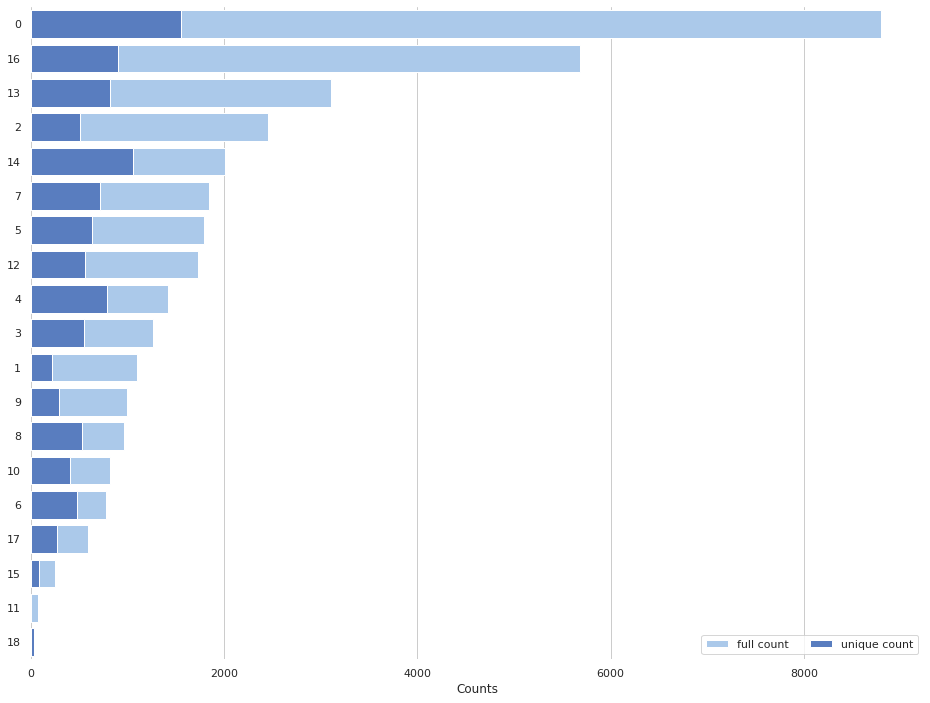

In [ ]:
labels = [str(i) for i in range(19)]

unique_counts = {}
for lbl in labels:
    unique_counts[lbl] = len(df_train[df_train.Label == lbl])

full_counts = {}
for lbl in labels:
    count = 0
    for row_label in df_train['Label']:
        if lbl in row_label.split('|'): count += 1
    full_counts[lbl] = count
    
counts = list(zip(full_counts.keys(), full_counts.values(), unique_counts.values()))
counts = np.array(sorted(counts, key=lambda x:-x[1]))
counts = pd.DataFrame(counts, columns=['label', 'full_count', 'unique_count'])

sns.set(style="whitegrid")
f, ax = plt.subplots(figsize=(16, 12))

sns.set_color_codes("pastel")
sns.barplot(x="full_count", y="label", data=counts, order=counts.label.values,
            label="full count", color="b", orient = 'h')

# Plot the crashes where alcohol was involved
sns.set_color_codes("muted")
sns.barplot(x="unique_count", y="label", data=counts, order=counts.label.values,
            label="unique count", color="b", orient = 'h')

# Add a legend and informative axis label
ax.legend(ncol=2, loc="lower right", frameon=True)
ax.set(ylabel="",
       xlabel="Counts")
sns.despine(left=True, bottom=True)

What do these labels represent? The descriptions below are taken from [this notebook shared by the organizers](https://www.kaggle.com/lnhtrang/single-cell-patterns).

| Label | Name | Description |
|-|-|-|
| 0. | Nucleoplasm | The nucleus is found in the center of cell and can be identified with the help of the signal in the blue nucleus channel. A staining of the nucleoplasm may include the whole nucleus or of the nucleus without the regions known as nucleoli (Class 2). |
| 1. | Nuclear membrane | The nuclear membrane appears as a thin circle around the nucleus. It is not perfectly smooth and sometimes it is also possible to see the folds of the membrane as small circles or dots inside the nucleus. |
| 2. | Nucleoli | Nucleoli can be seen as slightly elongated circular areas in the nucleoplasm, which usually display a much weaker staining in the blue DAPI channel. The number and size of nucleoli varies between cell types. |
| 3. | Nucleoli fibrillar center | Nucleoli fibrillary center can appear as a spotty cluster or as a single bigger spot in the nucleolus, depending on the cell type. |
| 4. | Nuclear speckles | Nuclear speckles can be seen as irregular and mottled spots inside the nucleoplasm. |
| 5. | Nuclear bodies | Nuclear bodies are visible as distinct spots in the nucleoplasm. They vary in shape, size and numbers depending on the type of bodies as well as cell type, but are usually more rounded compared to nuclear speckles. |
| 6. | Endoplasmic reticulum | The endoplasmic reticulum (ER) is recognized by a network-like staining in the cytosol, which is usually stronger close to the nucleus and weaker close to the edges of the cell. The ER can be identified with the help of the staining in the yellow ER channel. |
| 7. | Golgi apparatus | The Golgi apparatus is a rather large organelle that is located next to the nucleus, close to the centrosome, from which the microtubules in the red channel originate. It has a folded ribbon-like appearance, but the shape and size can vary between cell types, and in response to cellular various processes. |
| 8. | Intermediate filaments | Intermediate filaments often exhibit a slightly tangled structure with strands crossing every so often. They can appear similar to microtubules, but do not match well with the staining in the red microtubule channel. Intermediate filaments may extend through the whole cytosol, or be concentrated in an area close to the nucleus. |
| 9. | Actin filaments | Actin filaments can be seen as long and rather straight bundles of filaments or as branched networks of thinner filaments. They are usually located close to the edges of the cells. |
| 10. | Microtubules | Microtubules are seen as thin strands that stretch throughout the whole cell. It is almost always possible to detect the center from which they all originate (the centrosome). And yes, as you might have guessed, this overlaps the staining in the red channel. |
| 11. | Mitotic spindle | The mitotic spindle can be seen as an intricate structure of microtubules radiating from each of the centrosomes at opposite ends of a dividing cell (mitosis). At this stage, the chromatin of the cell is condensed, as visible by intense DAPI staining. The size and exact shape of the mitotic spindle changes during mitotic progression, clearly reflecting the different stages of mitosis. |
| 12. | Centrosome | This class includes centrosomes and centriolar satellites. They can be seen as a more or less distinct staining of a small area at the origin of the microtubules, close to the nucleus. When a cell is dividing, the two centrosomes move to opposite ends of the cell and form the poles of the mitotic spindle. |
| 13. | Plasma membrane | This class includes plasma membrane and cell junctions. Both are at the outer edge of the cell. Plasma membrane sometimes appears as a more or less distinct edge around the cell, occasionally with characteristic protrusions or ruffles. In some cell lines, the staining can be uniform across the entire cell. Cell junctions can be observed at contact sites between neighboring cells. |
| 14. | Mitochondria | Mitochondria are small rod-like units in the cytosol, which are often distributed in a thread-like pattern along microtubules. |
| 15. | Aggresome | An aggresome can be seen as a dense cytoplasmic inclusion, which is usually found close to the nucleus, in a region where the microtubule network is disrupted. |
| 16. | Cytosol | The cytosol extends from the plasma membrane to the nuclear membrane. It can appear smooth or granular, and the staining is often stronger close to the nucleus. |
| 17. | Vesicles and punctate cytosolic patterns | This class includes small circular compartments in the cytosol: Vesicles, Peroxisomes (lipid metabolism), Endosomes (sorting compartments), Lysosomes (degradation of molecules or eating up dead molecules), Lipid droplets (fat storage), Cytoplasmic bodies (distinct granules in the cytosol). They are highly dynamic, varying in numbers and size in response to environmental and cellular cues. They can be round or more elongated. |
| 18. | Negative | This class include negative stainings and unspecific patterns. This means that the cells have no green staining (negative), or have staining but no pattern can be deciphered from the staining (unspecific). |

Ok, so the class 18 which we found with very few examples is actually the "everything else" category - this can influence our labeling strategy. 

## 1.3. Combinations of classes

We already have a feeling for the volume of images with a single class. What do the combinations of these classes look like? 

In [ ]:
print(f'Number of unique combinations of classes in the train set: {len(df_train.Label.value_counts())}')

Number of unique combinations of classes in the train set: 432


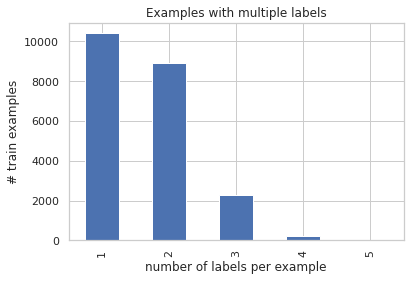

In [ ]:
df_train['num_classes'] = df_train['Label'].apply(lambda r: len(r.split('|')))
df_train['num_classes'].value_counts().plot.bar(title='Examples with multiple labels', xlabel='number of labels per example', ylabel='# train examples')
plt.show()

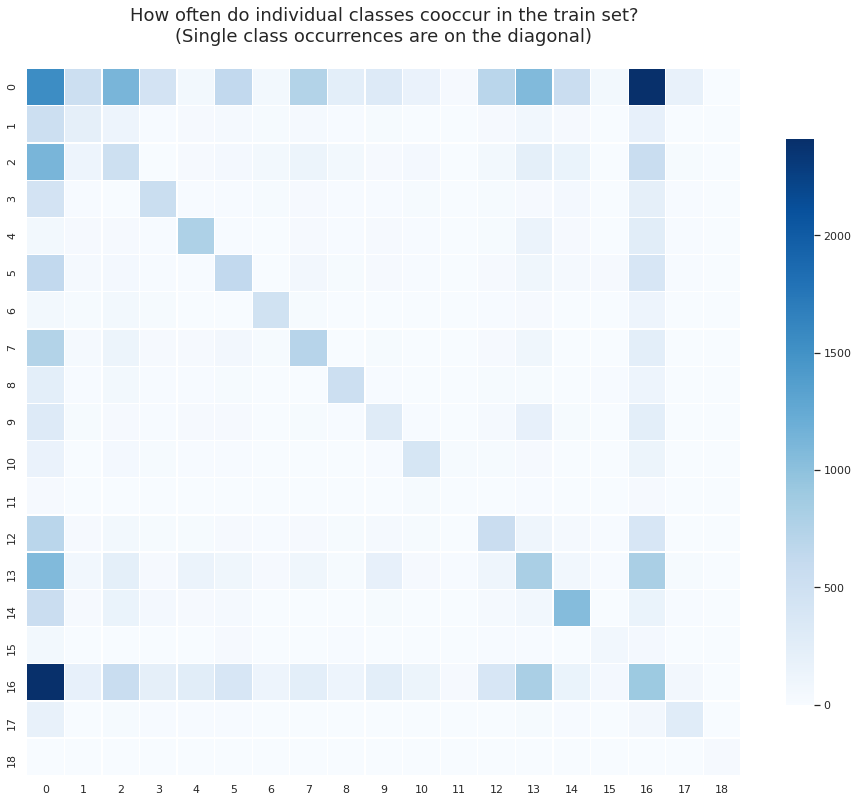

In [ ]:
for x in labels: df_train[x] = df_train['Label'].apply(lambda r: int(x in r.split('|')))

df_labels = df_train[labels]
coocc = df_labels.T.dot(df_labels)
for i in range(19): coocc.iloc[i,i] = int(counts.unique_count[counts.label == str(i)].values[0])

fig, ax = plt.subplots(figsize=(16, 13))
sns.heatmap(coocc, cmap="Blues", linewidth=0.3, cbar_kws={"shrink": .8})
title = 'How often do individual classes cooccur in the train set?\n(Single class occurrences are on the diagonal)\n'
plt.title(title, loc='center', fontsize=18)
plt.show()

We can see from the coocurrence plot that the classes 0 (nucleoplasm) and 16 (cytosol) tend to cooccur most frequently with other classes, and especially with each other. These are also the most frequent classes.

In [ ]:
# # I'll try another approach where we normalize the frequencies and compare them to random distribution based on class weights. 
# label_probs = counts.full_count.values.astype(int)/counts.full_count.values.astype(int).sum()
# label_probs = np.expand_dims(label_probs, axis=0)
# lprobs = label_probs.T @ label_probs
# df_probs = pd.DataFrame(lprobs, columns=labels)

# coocc_new = coocc.copy().astype(float)
# coocc_new = coocc_new.reset_index(drop=True)
# for i, row in coocc_new.iterrows():
# #     total = row.values.sum()
#     for j in range(len(row)):
#         row[j] /= len(df_train)

# norm_cooc = coocc_new - df_probs

# fig, ax = plt.subplots(figsize=(16, 13))
# sns.heatmap(norm_cooc, cmap="Blues", linewidth=0.3, cbar_kws={"shrink": .8})
# title = 'Actual vs expected class coocurrence\n'
# plt.title(title, loc='center', fontsize=18)
# plt.show()

# 2. Images <a class="anchor" id="images"></a>

## 2.1. Channels

In [ ]:
mt = [path/'train'/(id+'_red.png') for id in df_train.ID.values]
er = [path/'train'/(id+'_yellow.png') for id in df_train.ID.values]
nu = [path/'train'/(id+'_blue.png') for id in df_train.ID.values]
pr = [path/'train'/(id+'_green.png') for id in df_train.ID.values]
images = [mt, er, nu, pr]
titles = ['microtubules', 'endoplasmic reticulum', 'nucleus', 'protein of interest']

Let's again try to understand the image data provided, and see if we can visualize it. All images have 4 channels: 
- Red (Microtubules)
- Green (Protein of interest)
- Blue (Nucleus)
- Yellow (Endoplasmic reticulum)

What does [Wikipedia](https://en.wikipedia.org/wiki/Cytoskeleton) tell us these channels represent?
- **Microtubules** are polymers of tubulin that form part of the cytoskeleton and provide structure and shape to eukaryotic cells. Microtubules can grow as long as 50 micrometres and are highly dynamic. The microtubule cytoskeleton is involved in the transport of material within cells, carried out by motor proteins that move on the surface of the microtubule. They are involved in maintaining the structure of the cell and, together with microfilaments and intermediate filaments, they form the cytoskeleton...
- **Nucleus** is a membrane-bound organelle found in eukaryotic cells. Eukaryotes usually have a single nucleus, but a few cell types, such as mammalian red blood cells, have no nuclei, and a few others including osteoclasts have many. The cell nucleus contains all of the cell's genome, except for the small amount of mitochondrial DNA. The nucleus maintains the integrity of genes and controls the activities of the cell by regulating gene expression. The nucleus is, therefore, the control center of the cell.
- The **endoplasmic reticulum** (ER) is, in essence, the transportation system of the eukaryotic cell, and has many other important functions such as protein folding. It is a type of organelle made up of two subunits – rough endoplasmic reticulum (RER), and smooth endoplasmic reticulum (SER). The endoplasmic reticulum is found in most eukaryotic cells and forms an interconnected network of flattened, membrane-enclosed sacs known as cisternae (in the RER), and tubular structures in the SER.
- **Protein of interest** - I still need to understand this better, I assume the researchers are interested in certain types of proteins, which are not disclosed, and these proteins are marked in this channel.

Let's see an example of each channel below. 

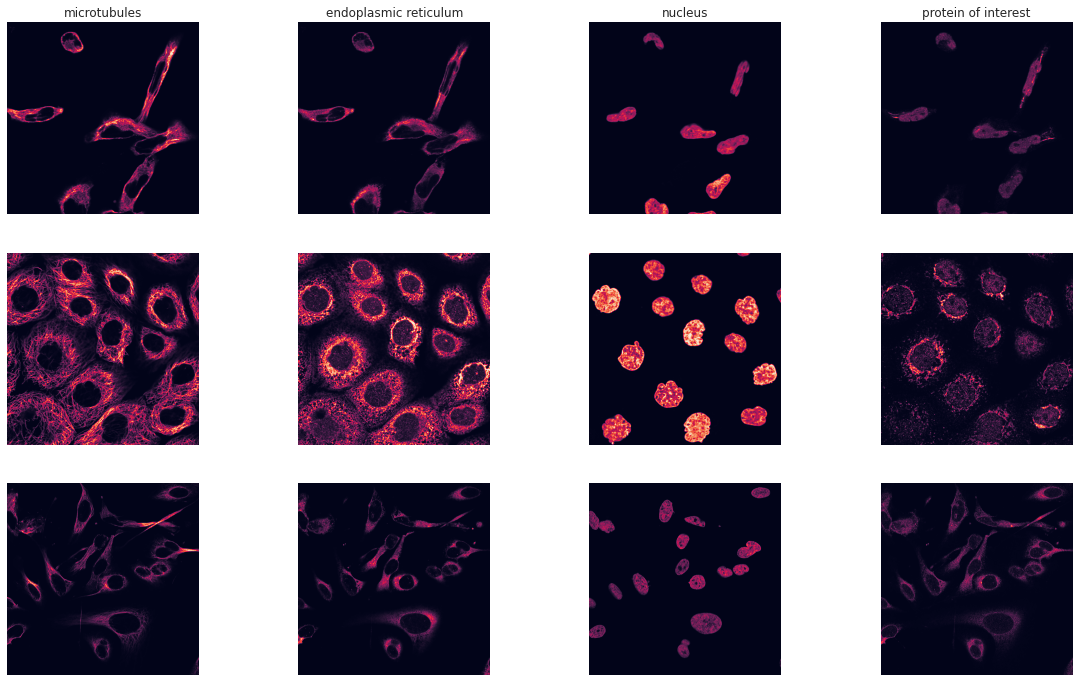

In [ ]:
fig, ax = plt.subplots(3,4, figsize=(20,12))
for j in range(3):
    for i in range(4):
        img = plt.imread(images[i][j])
        if j == 0: ax[j,i].set_title(titles[i])
        ax[j,i].imshow(img)
        ax[j,i].axis('off')
plt.show()

## 2.2. Combining Channels

These are 4 channels, how do we display them in a single image? According to a comment from competition host, [we could blend them](https://www.kaggle.com/c/hpa-single-cell-image-classification/discussion/214603). Looking at the notebook shared by the hosts, they visualize using 3 channels: red, yellow, blue. Let's see how it looks. 

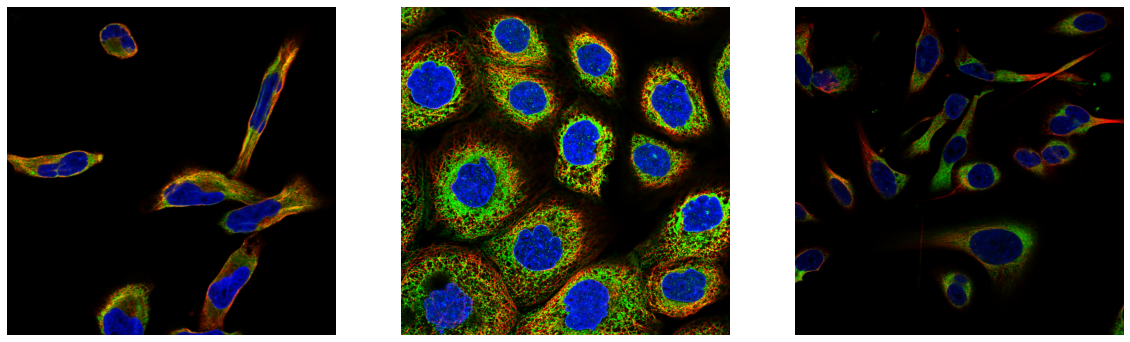

In [ ]:
fig, ax = plt.subplots(1,3, figsize=(20,50))
for i in range(3):
    microtubule = plt.imread(mt[i])    
    endoplasmicrec = plt.imread(er[i])    
    nuclei = plt.imread(nu[i])
    img = np.dstack((microtubule, endoplasmicrec, nuclei))
    ax[i].imshow(img)
    ax[i].axis('off')
plt.show()

What if we visualize the red, green and blue channels instead? 

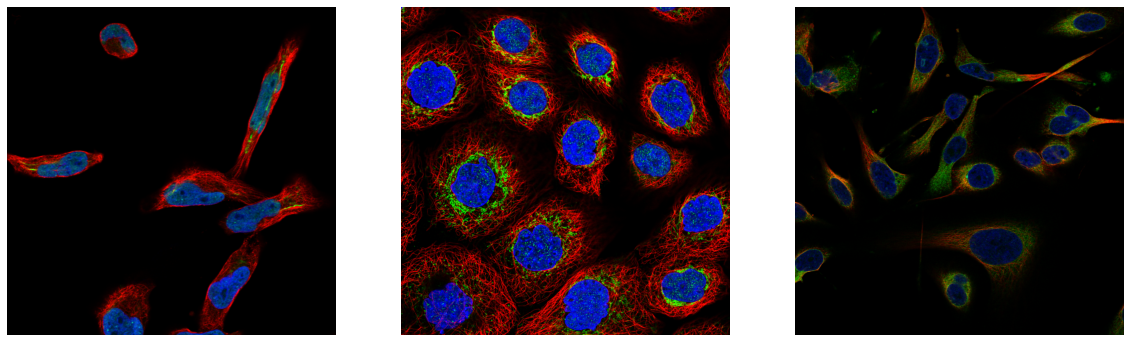

In [ ]:
fig, ax = plt.subplots(1,3, figsize=(20,50))
for i in range(3):
    microtubule = plt.imread(mt[i])    
    protein = plt.imread(pr[i])    
    nuclei = plt.imread(nu[i])
    img = np.dstack((microtubule, protein, nuclei))
    ax[i].imshow(img)
    ax[i].axis('off')
plt.show()

Ok, these look similar. I'll explore the blending later on, for now let's stick with the organizers' approach.

## 2.3. Visualize single classes

In the following section I'd like to visualize an image for each class (only images representing single class).


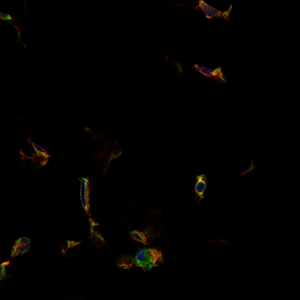
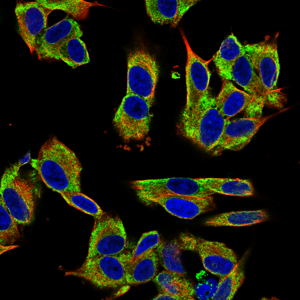
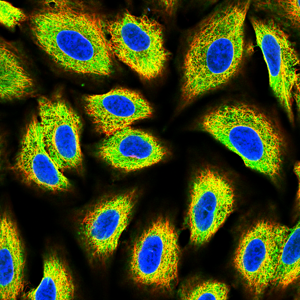
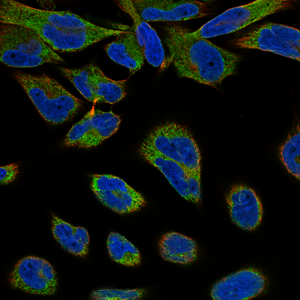
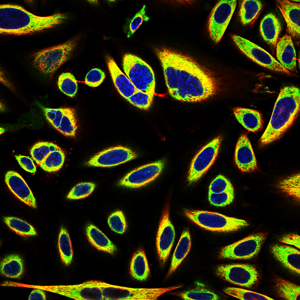
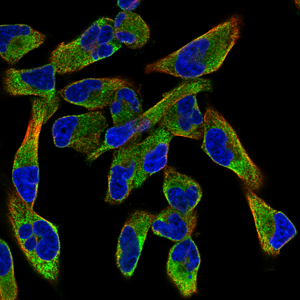
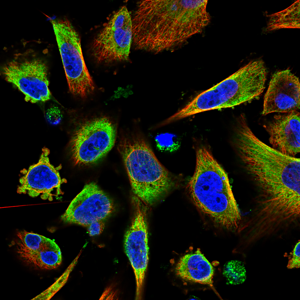
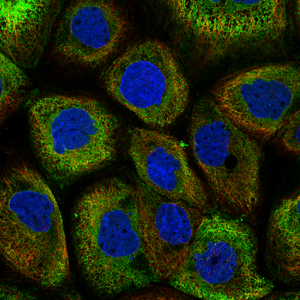
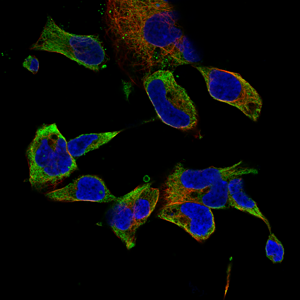
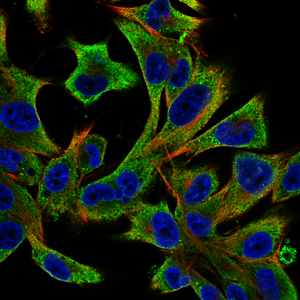
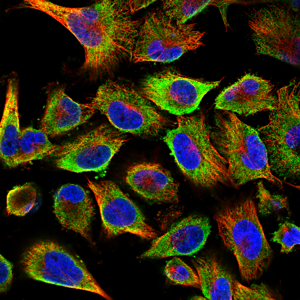
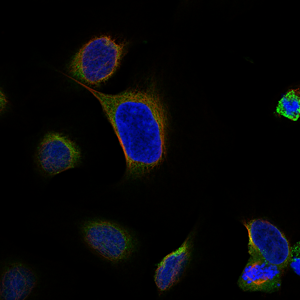
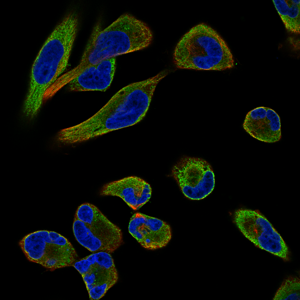
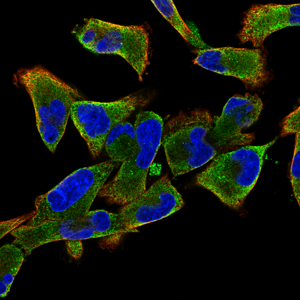
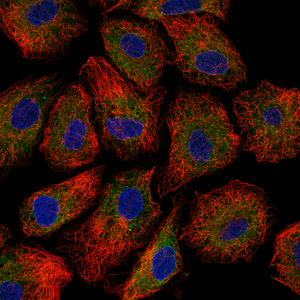
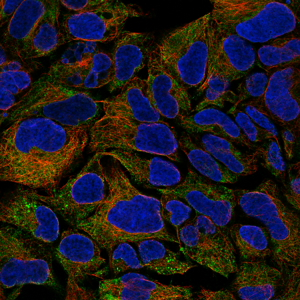
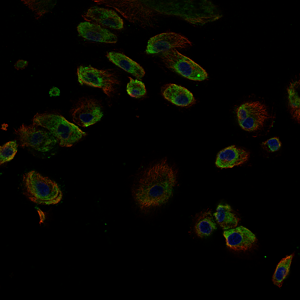
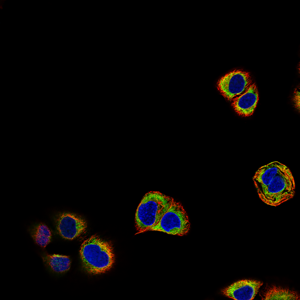
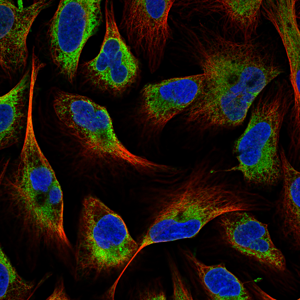


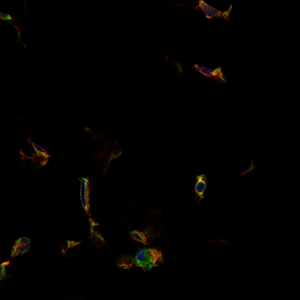
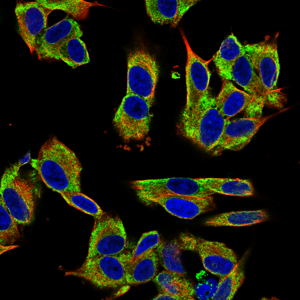
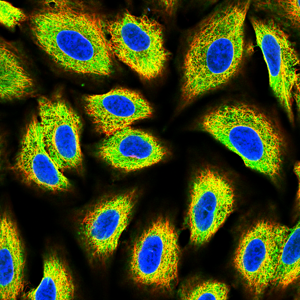
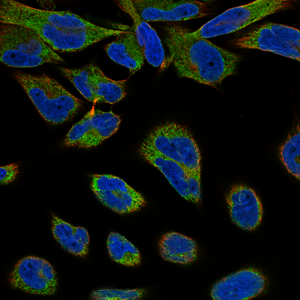
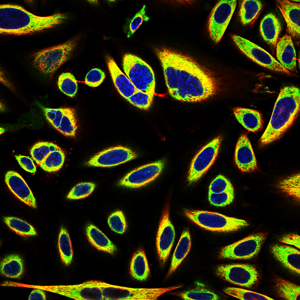
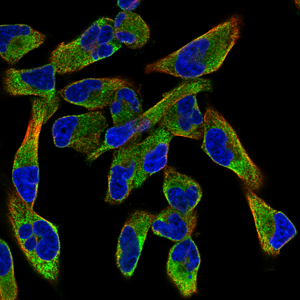
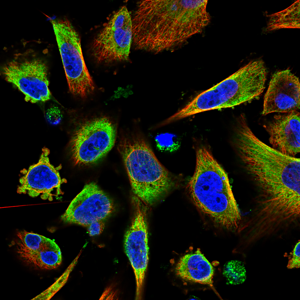
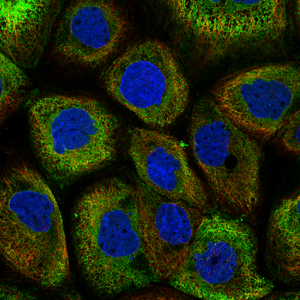
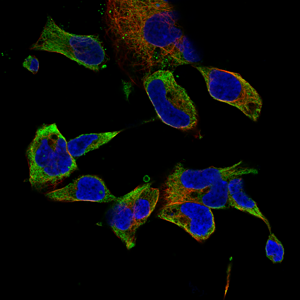
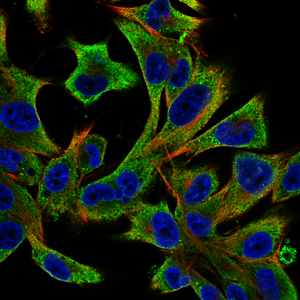
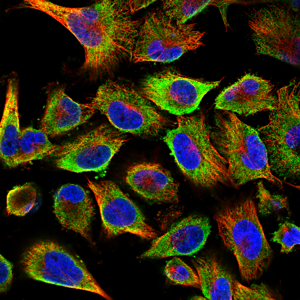
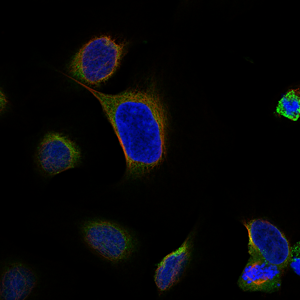
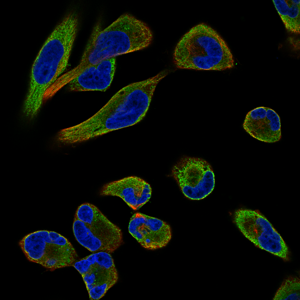
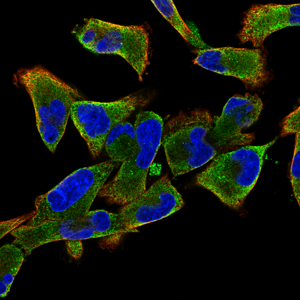
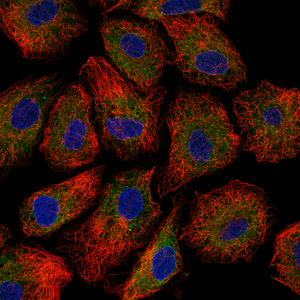
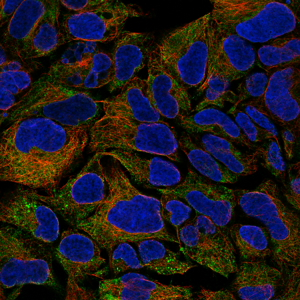
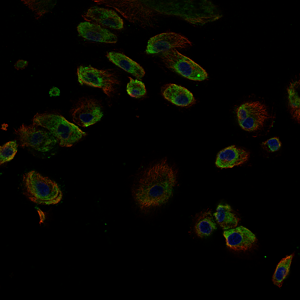
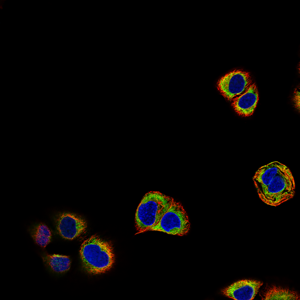
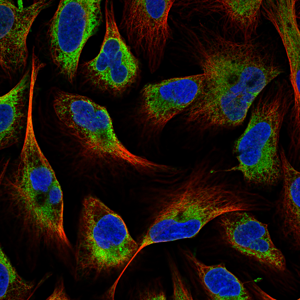

In [ ]:
class_images = []
for label in labels:
    r_img = df_train[df_train.Label == label].reset_index(drop=True).ID.loc[0] + '_red.png'
    y_img = df_train[df_train.Label == label].reset_index(drop=True).ID.loc[0] + '_yellow.png'
    b_img = df_train[df_train.Label == label].reset_index(drop=True).ID.loc[0] + '_blue.png'
    r = imageio.imread(path/'train'/r_img)
    y = imageio.imread(path/'train'/y_img)
    b = imageio.imread(path/'train'/b_img)
    rgb = np.dstack((r,y,b))
    class_images.append(PILImage.create(rgb))

codes = [
'0. Nucleoplasm',
'1. Nuclear membrane',
'2. Nucleoli',
'3. Nucleoli fibrillar center',
'4. Nuclear speckles',
'5. Nuclear bodies',
'6. Endoplasmic reticulum',
'7. Golgi apparatus',
'8. Intermediate filaments',
'9. Actin filaments',
'10. Microtubules',
'11. Mitotic spindle',
'12. Centrosome',
'13. Plasma membrane',
'14. Mitochondria',
'15. Aggresome',
'16. Cytosol',
'17. Vesicles and punctate cytosolic patterns',
'18. Negative'
]

ipyplot.plot_images(images=class_images, labels=codes, max_images=19, img_width=300)

# 3. Metric <a class="anchor" id="metric"></a>

Placeholder given the info on metric change.

> The metrics works like this: For each image, all predicted masks are matched with ground-truth masks. Then mAP is calculated. If the model predict a class 0 wrongly for cell 1 in image A, this is counted as 1 False Positive for class 0. If the model predicts a class on a region of the image that is not a cell, this is also counted as 1 False Positive for that class. [link](https://www.kaggle.com/c/hpa-single-cell-image-classification/discussion/214659)

Here's a link to [some tips on mAP from @its7171](https://www.kaggle.com/c/hpa-single-cell-image-classification/discussion/217158):
>* The lower the confidence threshold, the higher the mAP we will get.
>* Class dependence is linear.
>* small sample class is equaly important as bit class.

# 4. Competition Notes <a class="anchor" id="notes"></a>

Here is a collection of notes from various notebooks and forum posts
> The same type of data was used in a previous [Human Protein Atlas Classification challenge](https://www.kaggle.com/c/human-protein-atlas-image-classification) that aimed to classify image level labels ([paper](https://www.nature.com/articles/s41592-019-0658-6.epdf?no_publisher_access=1&r3_referer=nature)). The results are published and you can read the discussion on the strategies of the winning teams. In the hidden test set of this challenge, we purposely chose images with high single cell variation (SCV). Therefore I believe you won’t gain significant advantages with a metric learning approach (like the winning solution last challenge). [link](https://www.kaggle.com/lnhtrang/single-cell-patterns)

> HPACellSegmentation was used as a basis followed my manual correction of the masks for the ground truth. Classes per single cell were subsequently assigned by annotators. [link](https://www.kaggle.com/c/hpa-single-cell-image-classification/discussion/214616)

> We cannot tell you exactly what the proteins (of interest) are now. All we can say is that in this competition a large part of all human proteins are included in either the train or test set. These proteins are involved in a variety of biological processes. [link](https://www.kaggle.com/c/hpa-single-cell-image-classification/discussion/214616)

> The dataset is acquired in a highly standardized way using one imaging modality (confocal microscopy). However, the dataset comprises 17 different cell types of highly different morphology, which affect the protein patterns of the different organelles. All image samples are represented by four filters (stored as individual files), the protein of interest (green) plus three cellular landmarks: nucleus (blue), microtubules (red), endoplasmic reticulum (yellow). The green filter should hence be used to predict the label, and the other filters are used as references. [link](https://www.kaggle.com/c/hpa-single-cell-image-classification/data)

> The labels you will get for training are image level labels while the task is to predict cell level labels. That is to say, each training image contains a number of cells that have collectively been labeled as described above and the prediction task is to look at images of the same type and predict the labels of each individual cell within those images. As the training labels are a collective label for all the cells in an image, it means that each labeled pattern can be seen in the image but not necessarily that each cell within the image expresses the pattern. This imprecise labeling is what we refer to as weak. During the challenge you will both need to segment the cells in the images and predict the labels of those segmented cells. [link](https://www.kaggle.com/c/hpa-single-cell-image-classification/data)

> Note that a mask MAY have more than one class. If that is the case, predict separate detections for each class using the same mask. [link](https://www.kaggle.com/c/hpa-single-cell-image-classification/overview/evaluation)

> we get the absolute X and Y coordinates for the proteins from the green channel but that information is useless without the context provided by the other channels. The challenge lies in understanding which patterns can be seen in each cell, i.e. understanding which organelle(s) (cell part) the protein localizes to in the specific cell. For example, if there is overlap between the red channel (Microtubules) and the green (protein) we can understand that the protein localizes to the microtubules. [link](https://www.kaggle.com/c/hpa-single-cell-image-classification/discussion/215981)

> Note that Negative cells will be present in images labeled as other classes as well. This means that, for example, if image A has image-level label 0 1, not all single cells inside this image will have a pattern and some cells can have label 18 (Negative). [link](https://www.kaggle.com/lnhtrang/single-cell-patterns)

> The labels are the organelles/structures in which the proteins are located. So you are correct in assuming that the labels only apply to the cells where green is present (as the green is the protein). If there are 4 cells and 3 have green staining and the image-level labels are Mitochondria, and Nucleoplasm.
Cell 1: Green looks to be in the Mitochondria. Therefore, the cell level is Mitochondria.
Cell 2: Green looks to be in the Nucleoplasm. Therefore, the cell level is Nucleoplasm.
Cell 3: Green looks to be in the Nucleoplasm and Mitochondria. Therefore, the cell level label is Nucleoplasm and Mitochondria
Cell 4: No green or green is not present in any organelle. Therefore, the cell level label is Negative. [comment by @dschettler8845](https://www.kaggle.com/c/hpa-single-cell-image-classification/discussion/215736)

> Please also note that border cells where most of the cells are out of the field of view and to cells that have been damaged or suffer from staining artifacts. A good rule of thumb (that our annotators used in generating ground truth) is if more than half of the cell is not present, don't predict it! [link](https://www.kaggle.com/lnhtrang/single-cell-patterns)

> For some images, all cells will inherit the labels from image-level labels. For example, the first image in this section has image-level label Nucleoplasm & Mitochrondria, and all the single cells in this image display both patterns. For other images (especially in the test set), each cell will have only a part of the image-level label, or completely new label (18 Negative). For example, the middle image in this section has image-level label ER & Golgi, but the single cells in this image have either only ER or only Golgi (part of image-level label). And the first image in this section has image-level label Nucleoplasm, Cytokinetic bridge and Mitotic spindle. However, many individual cells only have Nucleoplasm as label, and many don’t have green staining, hence they are Negative. [link](https://www.kaggle.com/lnhtrang/single-cell-patterns)

> Just like people, all cells are different in terms of their morphology (shape, size) and they can also differ in the spatial distribution of their proteins. This is called single cell variability (SCV), and has been observed across images in HPA and been described in numerous scientific publications. The phenomenon of how genetically identical cells can show functional heterogeneity (for example in response to drug treatment), is poorly understood. We want to study this observed variation to better understand the functional heterogeneity of cells. Therefore a single cell classifier is more helpful than a whole image classifier (as developed in the previous challenge). [link](https://www.kaggle.com/lnhtrang/single-cell-patterns)

> A cell line is, like your explanation says, a population of cells that can be grown for a long time. We grow cells in our lab and take some of them for each imaging experiment. This means that we will have multiple images from the same cell line. It does not mean that we have the same cells between images, as different cells will be sampled for experiments. 
As for if characteristics of the cell line would improve the classification accuracy, that is certainly an interesting theory. In one of our previous papers (https://www.nature.com/articles/nbt.4225), we did show that including different cell lines in our training data helped accuracy across the board (Figure 5C of that paper). This could mean cell line information may be helpful for a neural network, but we have not tested, much less proved, that theory. If you think it will be helpful, feel free to try it. [link](https://www.kaggle.com/c/hpa-single-cell-image-classification/discussion/215981)

> In total, there are 19 classes (0-18) that will be scored. These patterns sometimes vary among 17 cell lines in this competition: A-431, A549, EFO-21, HAP1, HEK 293, HUVEC TERT2, HaCaT, HeLa, PC-3, RH-30, RPTEC TERT1, SH-SY5Y, SK-MEL-30, SiHa, U-2 OS, U-251 MG, hTCEpi. [link](https://www.kaggle.com/lnhtrang/single-cell-patterns)

> Single or muliple-patterns can be seen together in a cell. Any combination of patterns can be possible for a single cell, except 18 (if the cell's staining is Negative, there isn't any other pattern). [link](https://www.kaggle.com/lnhtrang/single-cell-patterns)

> the red channel will help you to identify a microtubule pattern (label 10) in the green channel, and the yellow channel will help you identify an ER pattern (label 6) in the green channel. The reference channels (red/green/blue) can also help you to get an overview of the cell - certain patterns will always be distributed in a certain way in correlation to these. For example, labels 2 to 5 are all within the nucleus (i.e. the region of each cell with a signal in the blue channel). [link](https://www.kaggle.com/c/hpa-single-cell-image-classification/discussion/215736)

> All images have all the four channels, and signals from the markers (blue, yellow, red) are present in all cells in the image, independent of the green channel that you are classifying, in order to help you identify where the cells are, as well as where certain structures and regions within the cells are. This can in turn help you to segment the cells and to classify each cell to one or more label(s) according to the signal in the green channel. Note that each of the image-level labels can be present in all or in just a fraction of the individual cells in the image, and that some individual cells may also have additional labels, that are not mentioned among the image-level labels. [link](https://www.kaggle.com/c/hpa-single-cell-image-classification/discussion/215736)

> there may be images where a single cell have a label that was neglected at the image level (for example a weak cytosolic pattern). Managing such weak-labels is part of this challenge, and it's impact is something we will analyze at the end of the challenge. [link](https://www.kaggle.com/c/hpa-single-cell-image-classification/discussion/215736)

> the images in the hidden test set are 16-bit. [link](https://www.kaggle.com/c/hpa-single-cell-image-classification/discussion/215428)

> Every cell in an image will have one or multiple labels. If there is no specific green pattern (noisy or no signal) it should be labeled as negative. Note that border cells are only included as ground truth when there is enough information to decide on the label (as described in the data tab, and the single cell pattern notebook), i.e. when the majority of the cell area is represented in the image.
A cell can have multiple labels, but will never have Negative AND some-other-label. [link](https://www.kaggle.com/c/hpa-single-cell-image-classification/discussion/216924)

> I agree the Negative label is a bit unclear, and I too hope for answers of the above. Also, in the training data, can we consider this category as a "garbage term" or a "none of the above". If so, wouldn't it be equivalent to a category vector consisting only of zeros (or False or Null etc). Or is there some subtle distinction I don't see? >>>> Yes you are correct, it is a "none of the above" label, and can be treated as such. For practical scoring reasons on the Kaggle platform we're using the format where 'Negative' has a label of its own (18). [link](https://www.kaggle.com/c/hpa-single-cell-image-classification/discussion/216924)

> In this competition, you should submit the whole cell segmentation. From a research perspective, individual organelle segmentation is definitely an interesting task. But since they are morphologically so different as you see in the Single Cell Pattern notebook, and so are their functions, it is more efficient to develop and analyze a model for each organelle of interest. In fact this is what happens in the biological image analysis space right now with individual deep learning models for Mitochondria, Golgi etc. There are more considerations that we took into account when designing this challenge. We want to study the integrated cell, with organelles in relation to it. Cell segmentation task can be considered an auxiliary task (depending on your approach to modelling of course) on a generalized deep learning model of the cell. [link](https://www.kaggle.com/c/hpa-single-cell-image-classification/discussion/218309)

> It appears that 146 of the images contain duplicate classes (just one label duplicated) in their labels. This duplication only happens with the 9, 13, & 17 labels (Actin Filaments, Plasma Membrane, & Vesicles) >>>> In this competition, we merged some spatially similar (and functionally related) patterns into the same class. This was mentioned on the Single Cell Pattern notebook. The duplicates simply results from conversion code. For example, if an image has image-level label as Vesicles and Peroxisomes, then the code results in 17|17. [link](https://www.kaggle.com/c/hpa-single-cell-image-classification/discussion/217806)

> Image-level label uncertainty The image-level labels are what we refer to as weak or noisy. During annotation, the image-level labels are set per sample (i.e per a group of up to 6 images from the same sample). This means that the labels present in the majority of the images will be annotated. For negative samples it is not uncommon that lets say 4 images show no staining, while the remaining 2 show some unspecific staining or some granular pattern. If you compare the image-level label with the precise pattern observed in any given cell from this group of images, the label will be correct for the vast majority of cells, but perhaps not for all of them (as in your example 1 and 3 above). [link](https://www.kaggle.com/c/hpa-single-cell-image-classification/discussion/220748)

> Single cell label accuracy in test set The test set consists of images where each single cell has been annotated independently. Hence the accuracy of these labels is much better, and will be correct for each cell in every image. The statement below made by Trang Le, @lnhtrang, in our notebook explaining the patterns is correct for how the test set was annotated. *This class (Negative) includes negative stainings and unspecific patterns. This means that the cells have no green staining (negative) or have staining but no pattern can be deciphered from the staining (unspecific).* [link](https://www.kaggle.com/c/hpa-single-cell-image-classification/discussion/220748)

> More negative images can be found in the HPA public image data (external data), where they are annotated as "No Staining". [link](https://www.kaggle.com/c/hpa-single-cell-image-classification/discussion/220748)

> How to recognize unspecific patterns Unspecific patterns arise from the use of antibody reagents that do not function well, and do not bind to their intended target protein, but rather to all cellular structures (sometimes excluding the nucleolus). The second example from the top, and the cells of weaker intensity in the top image, are text-book examples of this. [link](https://www.kaggle.com/c/hpa-single-cell-image-classification/discussion/220748)

> The entire test set was hand-labeled the same way, and later split up into the public and test set. So the labeling accuracy should be similar in the private and public test set. [link](https://www.kaggle.com/c/hpa-single-cell-image-classification/discussion/214616)

> Yes you can find more images with mitotic spindles in the HPA public image dataset (external data). I would also like to explain why you only see few mitotic spindle patterns in the images with such labels. The image-level labels are what we refer to as weak or noisy. During annotation, the image-level labels are set per sample (i.e per a group of up to 6 images from the same sample). This means that common labels present will be annotated. Mitotic spindle is a cellular structure that appears when cells divide, which happens approximately once per 24 hours. This means that only 1 in 20-50 cells in a population will at any given time point show mitotic spindles. Hence, it is not uncommon that we see a spindle in 2 images from a sample but not in 4, yet all images would get the mitotic spindle label. The test set consists of images where each single cell has been annotated independently. Hence the accuracy of these labels is much better, and will be correct for each cell in every image. [link](https://www.kaggle.com/c/hpa-single-cell-image-classification/discussion/214616)

# 5. Baseline solution for rapid prototyping <a class="anchor" id="baseline"></a>

My baseline approach for this competition, inspired by @jhoward [solution for RSNA Intracranial Hemorrhage Detection](https://www.kaggle.com/c/rsna-intracranial-hemorrhage-detection/discussion/114214). I am extracting individual cells with HPA cell segmentator, labeling them with image-level labels and training a classifier based on that.

## 5.1. Create a prototyping dataset
What I need as an input to the classification model are images of individual cells. For experimentation I don't need all the images, instead I create a sample from the train set. The additional benefit is that my sample is more balanced than train. I use RGB channels only, which has proven to work well in the previous HPA challenge. I save the extracted cells as RGB jpg images so that I can feed them easily into my classifier. 
- [Notebook for creating the training dataset](https://www.kaggle.com/thedrcat/hpa-cell-tiles-sample-balanced)
- [Training Dataset](https://www.kaggle.com/thedrcat/hpa-cell-tiles-sample-balanced-dataset/)
- [Notebook for creating the public test dataset](https://www.kaggle.com/thedrcat/hpa-cell-tiles-test-with-enc/)
- [Public Test Dataset](https://www.kaggle.com/thedrcat/hpa-cell-tiles-test-with-enc-dataset)

## 5.2. Use fastai training loop with the data-block API
fastai is a great tool to create a strong baseline quickly. I use pretty much out of the box approach for multilabel classification, with resnet50 backbone, one cycle training, lr finder etc. The data block API is a great way to prepare the data, and comes with a default set of augmentations that I use as well. 
- [Training notebook](https://www.kaggle.com/thedrcat/fastai-cell-tile-prototyping-training/)

## 5.3. Quick submission template
I want to experiment quickly and can't wait for the lb score, especially that with weak labels I haven't found a reasonable way to do CV, and depend on the public lb score. I have pre-processed the public test images in the same way as my prototyping dataset and submit my preds only for this piece. These submissions will get zero score on private, but there is still lots of time in the competition and better approaches will be developed.
- [Submission template](https://www.kaggle.com/thedrcat/fastai-quick-submission-template) 

# 6. Solution Approaches <a class="anchor" id="solutions"></a>

Here is a collection of links to various solution approaches shared in competition notebooks and discussions. 

* Puzzle-CAM by @phalanx - weakly supervised semantic segmentation + hpasegmentor solution
    * https://www.kaggle.com/c/hpa-single-cell-image-classification/discussion/217395
    * https://github.com/OFRIN/PuzzleCAM
* mmdetection for segmentation by @its7171 - convert masks to bboxes and train an object detection model
    * https://www.kaggle.com/its7171/mmdetection-for-segmentation-training
    * https://www.kaggle.com/its7171/mmdetection-for-segmentation-inference
* HPA - classifier + explainability + segmentation by @samusram - build a classifier on top of image-level labels (multi-label classification), then use an explainability technique Guided-GRADCAM to extract regions responsible for particular class prediction, and then assign the segmented cells to particular classes based on the overlap with Grad-CAM outputs.
    * https://www.kaggle.com/samusram/hpa-classifier-explainability-segmentation
* Classification of segmented and cropped cells by @dschettler8845
    * https://www.kaggle.com/dschettler8845/hpa-cellwise-classification-training
    * https://www.kaggle.com/dschettler8845/hpa-cellwise-classification-inference
    

# 7. Resources <a class="anchor" id="resources"></a>

These resources may be helpful to learn more about the domain and/or approach these challenge. 

* Pretrained segmentation models
    * [Cellpose](https://www.cellpose.org/)
    * [HPACellSegmentation](https://github.com/CellProfiling/HPA-Cell-Segmentation)
    * [EmbedSeg - Embedding-based Instance Segmentation](http://github.com/juglab/EmbedSeg) via @tanlikesmath
* [Hosts' notebook](https://www.kaggle.com/lnhtrang/hpa-public-data-download-and-hpacellseg) demonstrating how you can make use of public HPA data and HPACellSegmentation model
* [Hosts' guide explaining the patterns and cells in the microscope images](https://www.kaggle.com/lnhtrang/single-cell-patterns)
* [Paper](https://www.nature.com/articles/s41592-019-0658-6.epdf?no_publisher_access=1&r3_referer=nature) describing results and approaches from the first HPA competition
* An assumption that the labels were created via online players in an [online game](https://wiki.eveuniversity.org/Project_Discovery:_Human_Protein_Atlas) - via @ryches, [link](https://www.kaggle.com/c/hpa-single-cell-image-classification/discussion/215122). This may be valid for train set, competition hosts explained that the test set was labelled by experts at HAP [link](https://www.kaggle.com/c/hpa-single-cell-image-classification/discussion/215141)
* [Comparative Study on Automated Cell Nuclei Segmentation Methods for Cytology Pleural Effusion Images](https://www.hindawi.com/journals/jhe/2018/9240389/) - via @weka511, [link](https://www.kaggle.com/c/hpa-single-cell-image-classification/discussion/216132)
* [Organelles by HPA](https://www.proteinatlas.org/humanproteome/cell/organelle)
* [Dictionary by HPA - Cell Structure part](https://www.proteinatlas.org/learn/dictionary/cell)
* [A few tips on mAP by tito](https://www.kaggle.com/its7171/a-few-tips-on-map?scriptVersionId=53590041)


## 7.1. Datasets

* [Single Cell Training Sample Dataset](https://www.kaggle.com/thedrcat/hpa-cell-tiles-sample-balanced-dataset/) - train dataset I created for my prototyping solution described in section 5. 
* [Single Cell Public Test Dataset](https://www.kaggle.com/thedrcat/hpa-cell-tiles-test-with-enc-dataset) - public test dataset I created for my prototyping solution described in section 5. 
* [Segmentation mask dataset](https://www.kaggle.com/c/hpa-single-cell-image-classification/discussion/215773) by @its7171
* [Cell crop tile datasets](https://www.kaggle.com/c/hpa-single-cell-image-classification/discussion/216984) by @dschettler8845
* [16bit training set](https://www.kaggle.com/philculliton/hpa-2020-16bit-training-set) - the original train set is 8bit, while test set is 16bit. It might be useful for the final models to get trained on 16bit images as well.

# To be continued...

Please upvote if you found this helpful, you will make my day :-)